In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# For Machine Learning (PyTorch)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

root = "tensile_fatigue_data_ong_raw.xlsx"
main_df = pd.read_excel(root)

In [2]:
def GBR_HYP(X_train, X_test, y_train, y_test):
    n_estimate = [30000, 50000]
    l_rate = [0.001, 0.01, 0.1, 0.2]
    m_depth = [2, 3, 4]
    max_test_score = 0
    max_n = 0
    max_l = 0
    max_d = 0
    
    # 'subsample': [0.8, 1.0]
    # 'min_samples_split': [2, 5]
    
    for x in range(len(n_estimate)):
        for y in range(len(l_rate)):
            for z in range(len(m_depth)):
                gbr = GradientBoostingRegressor(n_estimators = n_estimate[x],learning_rate = l_rate[y], max_depth = m_depth[z], random_state = 10, tol = 1e-5)
                gbr.fit(X_train, y_train)
    
                y_train_pred = gbr.predict(X_train)
                y_test_pred = gbr.predict(X_test)
    
                r2_train = r2_score(y_train, y_train_pred)
                r2_test  = r2_score(y_test, y_test_pred)
    
                print("GBR Parameters: n-estimators = ", n_estimate[x], " lr = ", l_rate[y], " max depth = ", m_depth[z])
                print("Train R²: ", "%.5f" % round(r2_train, 5))
                print("Test R² : ", "%.5f" % round(r2_test, 5))
    
                if r2_test > max_test_score:
                    max_test_score = r2_test
                    max_n = n_estimate[x]
                    max_l = l_rate[y]
                    max_d = m_depth[z]
    
    print("Best GBR Parameters: n-estimators = ", max_n, " lr = ", max_l, " max depth = ", max_d)
    return max_n, max_l, max_d

In [8]:
def GBR_DNN(variable):
    X = pd.read_excel(root,usecols=[0,1,2,3,4,5])
    y = pd.read_excel(root,usecols=[variable])
    
    # Normalize inputs
    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)
    
    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y)
    
    # Use scaled data
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=10)
    
    # Convert y to float and flatten
    y_train = np.array(y_train, dtype=np.float32).ravel()
    y_test = np.array(y_test, dtype=np.float32).ravel()

    a1, a2, a3 = GBR_HYP(X_train, X_test, y_train, y_test)
    
    # Train the Gradient Boosting Regressor #70000, 0.001, 4
    gbr = GradientBoostingRegressor(n_estimators= a1, learning_rate= a2, max_depth= a3, random_state=10, tol=1e-5)
    gbr.fit(X_train, y_train)
    
    # Get GBR predictions
    gbr_train_pred = gbr.predict(X_train)
    gbr_test_pred = gbr.predict(X_test)
    
    # Augment inputs
    X_train_nn = np.hstack([X_train, gbr_train_pred.reshape(-1, 1)])
    X_test_nn = np.hstack([X_test, gbr_test_pred.reshape(-1, 1)])
    
    # Convert to tensors
    X_train = torch.tensor(X_train_nn, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    X_test = torch.tensor(X_test_nn, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
    
    # Neural network class
    class DeepNN(nn.Module): #hidden = 32
        def __init__(self, input_size=7, hidden_size= 16, output_size=1):
            super(DeepNN, self).__init__()
            # self.fc1 = nn.Linear(input_size, hidden_size)
            # self.activation = nn.ReLU()
            # self.out = nn.Linear(hidden_size, output_size)
            self.fc1 = nn.Linear(input_size, hidden_size)
            self.fc2 = nn.Linear(hidden_size, hidden_size)
            self.fc3 = nn.Linear(hidden_size, hidden_size)
            self.fc4 = nn.Linear(hidden_size, hidden_size)
            self.fc5 = nn.Linear(hidden_size, hidden_size)
            self.fc6 = nn.Linear(hidden_size, output_size)
    
        def forward(self, x):
            # x = self.activation(self.fc1(x))
            x = torch.relu(self.fc1(x))
            x = torch.relu(self.fc2(x))
            x = torch.relu(self.fc3(x))
            x = torch.relu(self.fc4(x))
            x = torch.relu(self.fc5(x))
            x = self.fc6(x)
            return x
    
    # Model, loss, optimizer
    model = DeepNN()
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    
    # Training loop
    num_epochs = 1000
    for epoch in range(num_epochs):
        model.train()
        y_train_pred = model(X_train)
        loss = criterion(y_train_pred, y_train)
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        if (epoch + 1) % 50 == 0:
            model.eval()
            y_test_pred = model(X_test)
            train_r2 = r2_score(y_train.detach().numpy(), y_train_pred.detach().numpy())
            test_r2 = r2_score(y_test.detach().numpy(), y_test_pred.detach().numpy())
           
            print(f"Epoch {epoch+1}, Training Loss: {loss.item():.4f}")
            print("Train R²: ", "%.5f" % round(train_r2, 5))
            print("Test R² : ", "%.5f" % round(test_r2, 5))
    
            fig, axes = plt.subplots(2, 2, figsize = (7, 6))
            axes[0, 0].scatter(y_train, y_train_pred.detach().numpy())
            axes[0, 0].plot([min(y_train.data.numpy()), max(y_train.data.numpy())],[min(y_train.data.numpy()), max(y_train.data.numpy())], color = 'r')
            axes[0, 0].set_title("Training Data")
            axes[0, 0].set_xlabel("Actual values")
            axes[0, 0].set_ylabel("Predicted values")
    
            axes[0, 1].scatter(y_test, y_test_pred.detach().numpy())
            axes[0, 1].plot([min(y_test.data.numpy()), max(y_test.data.numpy())],[min(y_test.data.numpy()), max(y_test.data.numpy())], color = 'r')
            axes[0, 1].set_title("Test Data")
            axes[0, 1].set_xlabel("Actual values")
            axes[0, 1].set_ylabel("Predicted values")
    
            axes[1, 0].plot(y_train.data.numpy().squeeze(),'tab:orange', label = 'real')
            axes[1, 0].plot(y_train_pred.detach().numpy(),'tab:green',label = 'pred')
    
            axes[1, 1].plot(y_test.data.numpy().squeeze(), 'tab:orange',label = 'real')
            axes[1, 1].plot(y_test_pred.detach().numpy(),'tab:green',label = 'pred')
    
            plt.draw();plt.pause(0.05)
        
        plt.ioff()
        plt.show()

In [ ]:
GBR_DNN(6)

GBR Parameters: n-estimators =  30000  lr =  0.001  max depth =  2
Train R²:  0.99976
Test R² :  0.07422
GBR Parameters: n-estimators =  30000  lr =  0.001  max depth =  3
Train R²:  1.00000
Test R² :  -0.03831
GBR Parameters: n-estimators =  30000  lr =  0.001  max depth =  4
Train R²:  1.00000
Test R² :  -0.33243
GBR Parameters: n-estimators =  30000  lr =  0.01  max depth =  2
Train R²:  1.00000
Test R² :  0.07746
GBR Parameters: n-estimators =  30000  lr =  0.01  max depth =  3
Train R²:  1.00000
Test R² :  -0.01569
GBR Parameters: n-estimators =  30000  lr =  0.01  max depth =  4
Train R²:  1.00000
Test R² :  -0.31470
GBR Parameters: n-estimators =  30000  lr =  0.1  max depth =  2
Train R²:  1.00000
Test R² :  0.14044
GBR Parameters: n-estimators =  30000  lr =  0.1  max depth =  3
Train R²:  1.00000
Test R² :  -0.03499
GBR Parameters: n-estimators =  30000  lr =  0.1  max depth =  4
Train R²:  1.00000
Test R² :  0.02175
GBR Parameters: n-estimators =  30000  lr =  0.2  max depth

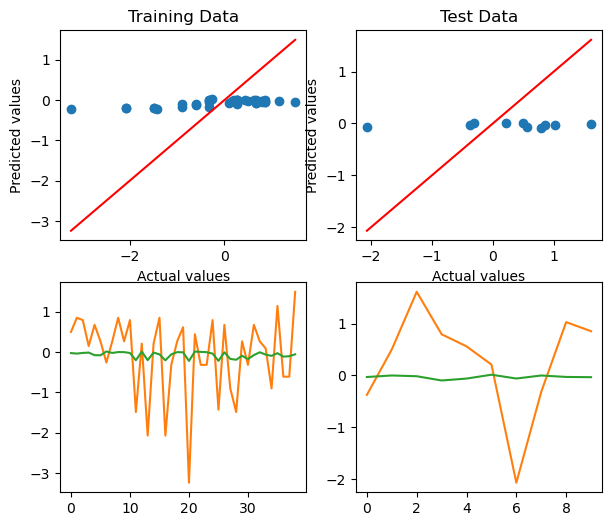

Epoch 100, Training Loss: 0.0770
Train R²:  0.92226
Test R² :  0.03442


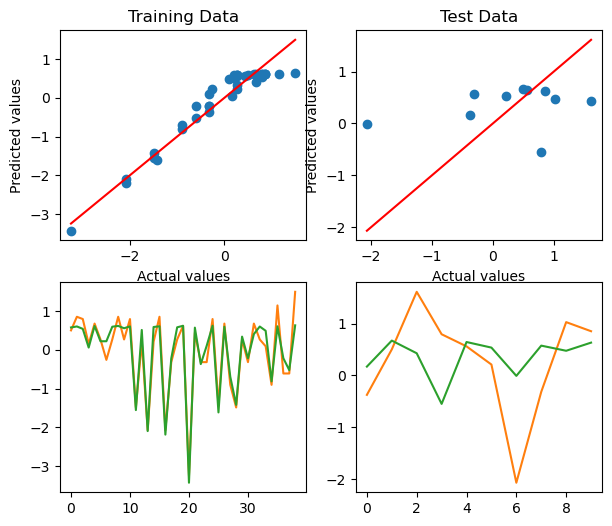

Epoch 150, Training Loss: 0.0173
Train R²:  0.98250
Test R² :  -0.00598


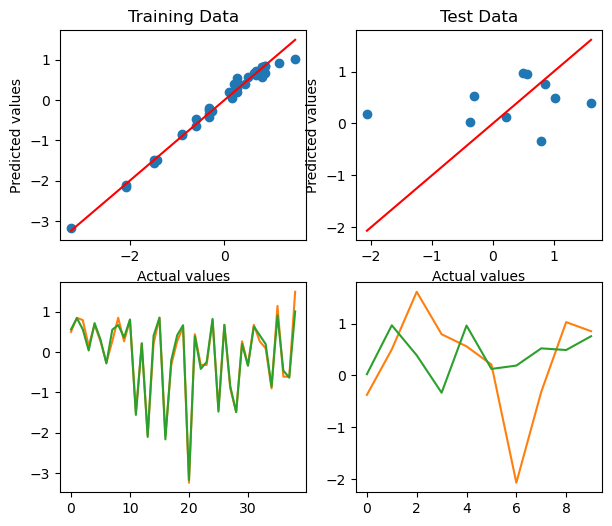

Epoch 200, Training Loss: 0.0068
Train R²:  0.99310
Test R² :  -0.05327


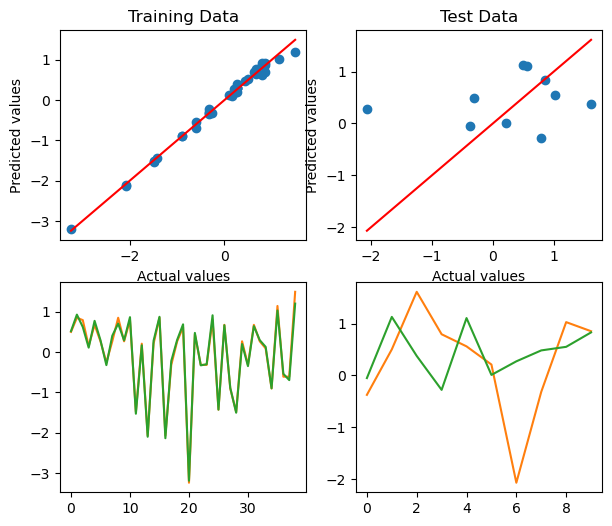

Epoch 250, Training Loss: 0.0033
Train R²:  0.99662
Test R² :  -0.01447


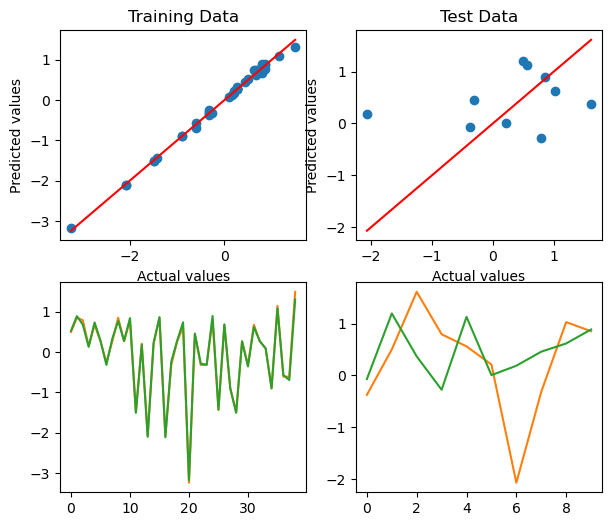

Epoch 300, Training Loss: 0.0020
Train R²:  0.99798
Test R² :  -0.00156


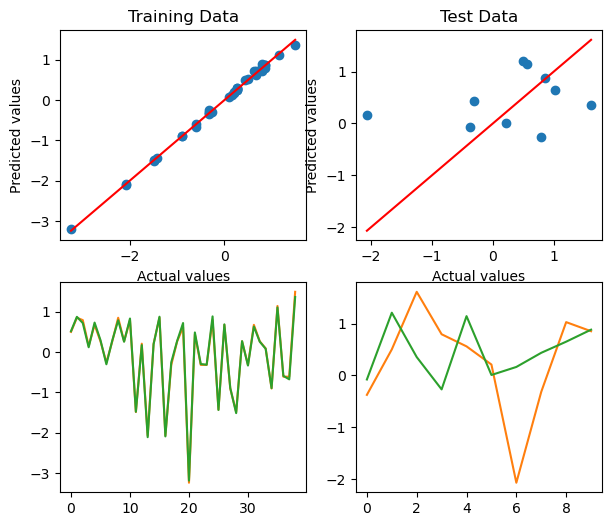

Epoch 350, Training Loss: 0.0014
Train R²:  0.99856
Test R² :  0.00397


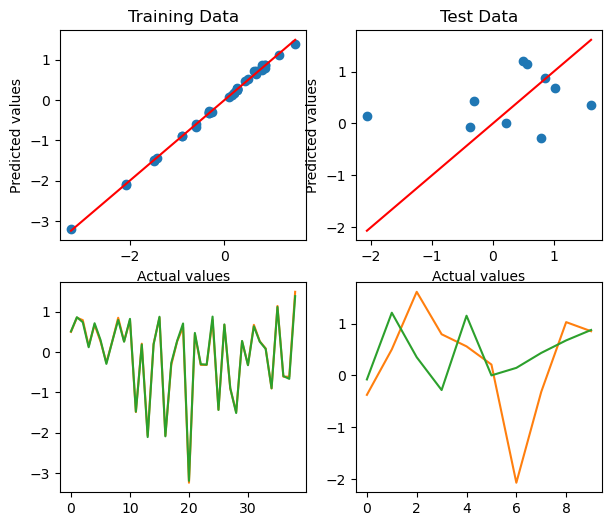

Epoch 400, Training Loss: 0.0011
Train R²:  0.99891
Test R² :  0.00477


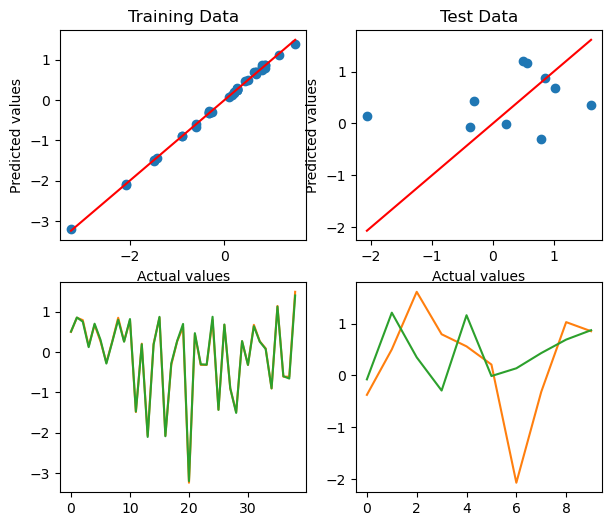

Epoch 450, Training Loss: 0.0009
Train R²:  0.99913
Test R² :  0.00309


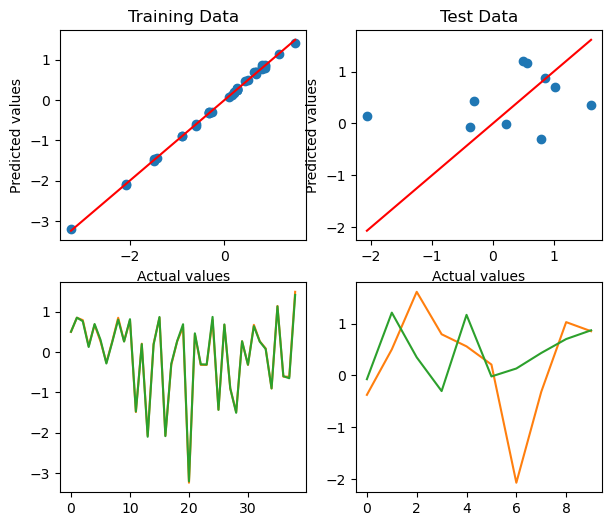

Epoch 500, Training Loss: 0.0007
Train R²:  0.99928
Test R² :  0.00240


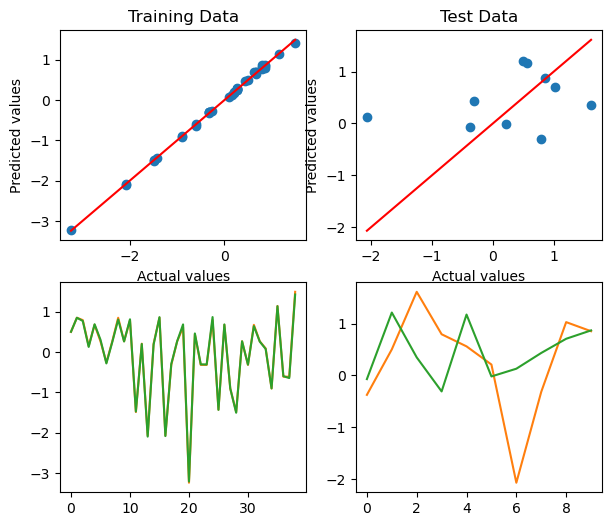

Epoch 550, Training Loss: 0.0006
Train R²:  0.99939
Test R² :  0.00282


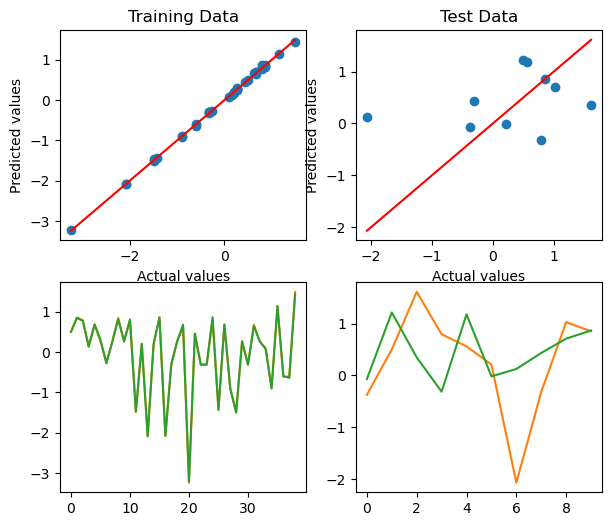

Epoch 600, Training Loss: 0.0005
Train R²:  0.99949
Test R² :  0.00290


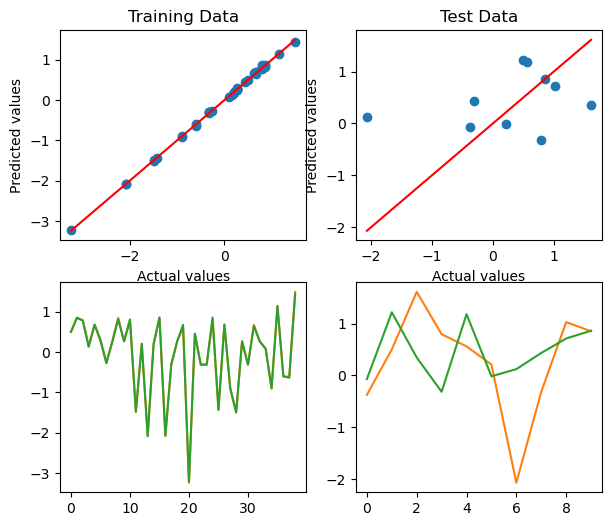

Epoch 650, Training Loss: 0.0004
Train R²:  0.99957
Test R² :  0.00309


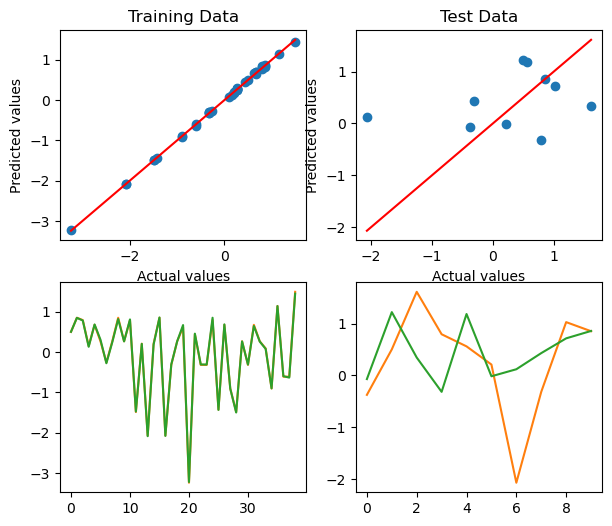

Epoch 700, Training Loss: 0.0004
Train R²:  0.99963
Test R² :  0.00347


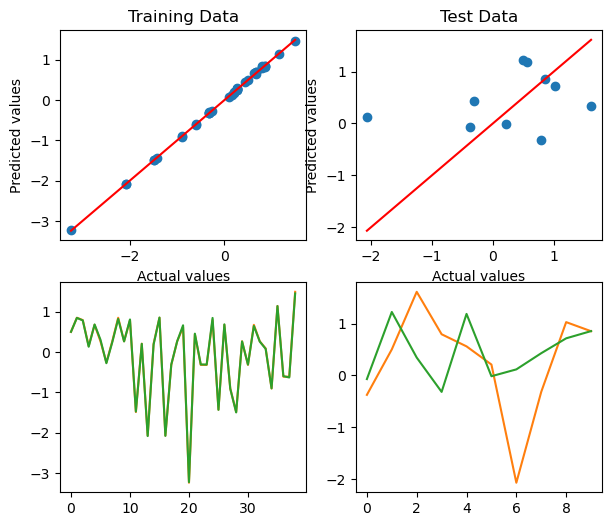

Epoch 750, Training Loss: 0.0003
Train R²:  0.99968
Test R² :  0.00349


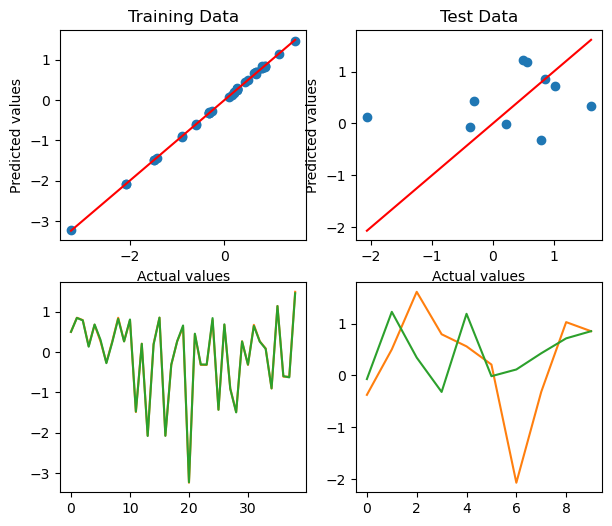

Epoch 800, Training Loss: 0.0003
Train R²:  0.99972
Test R² :  0.00352


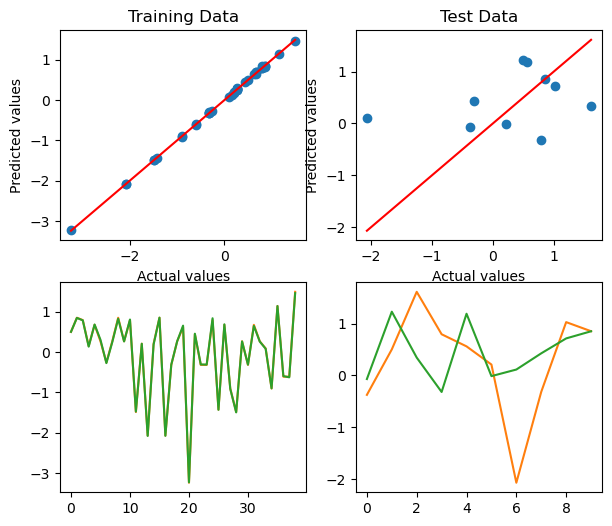

Epoch 850, Training Loss: 0.0002
Train R²:  0.99976
Test R² :  0.00287


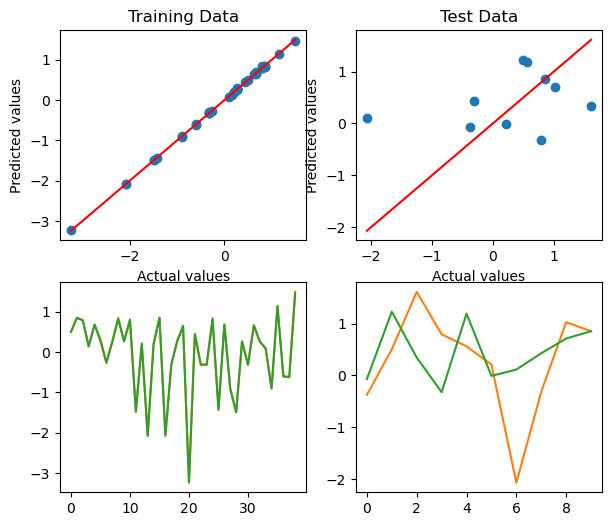

Epoch 900, Training Loss: 0.0002
Train R²:  0.99978
Test R² :  0.00269


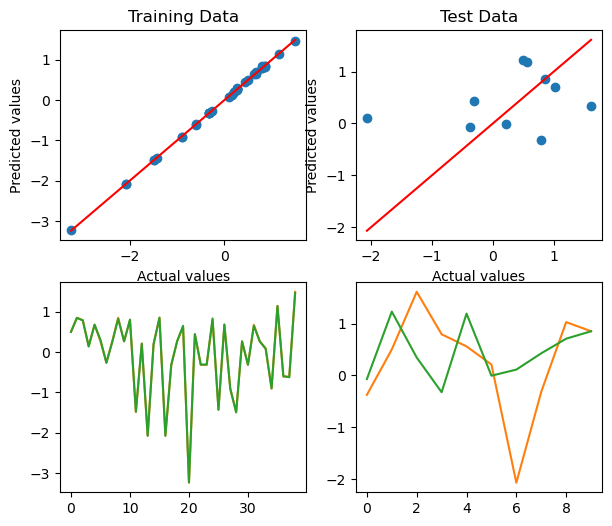

Epoch 950, Training Loss: 0.0002
Train R²:  0.99980
Test R² :  0.00225


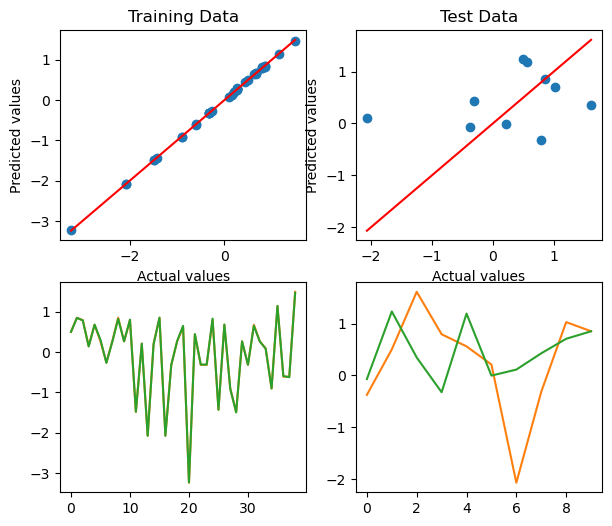

Epoch 1000, Training Loss: 0.0002
Train R²:  0.99982
Test R² :  0.00163


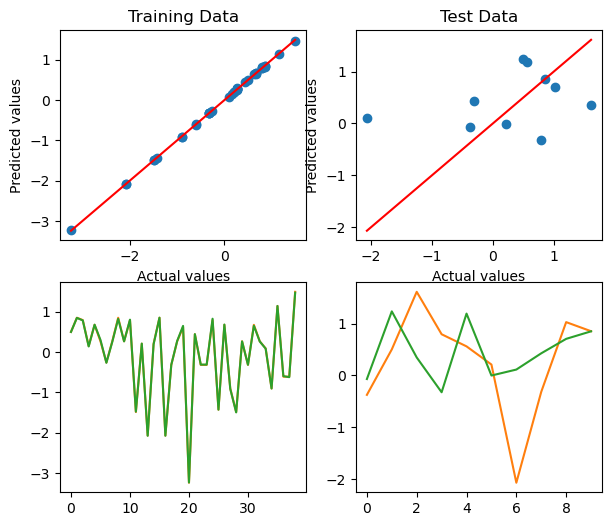

In [9]:
GBR_DNN(7)

In [ ]:
GBR_DNN(7)

In [ ]:
GBR_DNN(8)